# IMEX-RB: A Fast and Stable Time Integration Method


In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('..'))

In [2]:
import numpy as np
import scipy
from src.imexrb import imexrb
from src.euler import backward_euler, forward_euler
from src.problemsPDE import AdvDiff2D
import utils.mpl_pubstyle
from utils.errors import compute_errors
from utils.helpers import *

import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)
logging.getLogger('PIL.PngImagePlugin').setLevel(logging.WARNING)

14:47:47 - matplotlib - DEBUG - matplotlib data path: /home/riccardo/anaconda3/envs/IMEX/lib/python3.10/site-packages/matplotlib/mpl-data
14:47:47 - matplotlib - DEBUG - CONFIGDIR=/home/riccardo/.config/matplotlib
14:47:47 - matplotlib - DEBUG - interactive is False
14:47:47 - matplotlib - DEBUG - platform is linux


## Solving a 2D Advection-Diffusion equation

The advection–diffusion problem is defined over the spatial domain $\Omega = [0,2] \times [0,2]$ and the time interval $[0,1]$:

$$
\begin{cases}
\dfrac{\partial u}{\partial t} + c_x \dfrac{\partial u}{\partial x} + c_y \dfrac{\partial u}{\partial y} - \mu \Delta u = f(\mathbf{x},t),
  & \mathbf{x} \in \Omega,\; t > 0, \\[1em]
u(\mathbf{x}, 0) = u_0(\mathbf{x}), 
  & \mathbf{x} \in \Omega, \\[0.5em]
u(\mathbf{x}, t) = g(\mathbf{x}), 
  & \mathbf{x} \in \partial \Omega,
\end{cases}
$$

where $\mathbf{x} = [x, y]^{T}$. We choose the advection and diffusion parameters as
$$
\mathbf{c} = [c_x, c_y] = [1, 0.5], 
\quad
\mu = 0.02,
$$

while the forcing term is given by

$$
f(\mathbf{x}, t) = \frac{\mu U}{(\sigma^2 + \mu t)^2} \ \left( 4 (\sigma^2 + \mu t) - 3 \Vert \mathbf{x} - \mathbf{x_0} - \mathbf{c} t \Vert_2^2 \right) \ \exp\left( - \frac{\Vert \mathbf{x} - \mathbf{x_0} - \mathbf{c} t \Vert_2^2}{\sigma^2 + \mu t} \right)~,
$$

where we set $\mathbf{x_0} = [0.5, 0.5]$, $\sigma=0.5$ and $U = 0.25$.

The analytical solution writes as follows:

$$
u_{\mathrm{ex}}(x, y, t)
= U
  \exp\!\left(
    -\frac{\Vert \mathbf{x} - \mathbf{x_0} - \mathbf{c} t \Vert_2^2}{\sigma^2 + \mu t}
  \right)~;
$$

we note that $\sigma > 0$ regulates the amplitude of the peak in the initial condition and $U>0$ is the peak solution value at $t=0$. The initial and Dirichlet data are inferred from the exact solution.

---

We can now integrate in time, to show the performance of IMEX-RB compared to classic 1st order integration schemes, i.e. Backward/Forward Euler.

In [3]:
problem_name = "AdvDiff2D"

mu = 0.02
sigma = 0.5

Lx = 2
Ly = 2

vx = 1
vy = 0.5

t0 = 0.0
tf = 1.0
tspan = [t0, tf]

Nx = 101
Ny = 101

# Define the problem object
problem = AdvDiff2D(Nx, Ny, Lx, Ly, mu=mu, sigma=sigma, vx=vx, vy=vy, center=[0.5, 0.5])
u0 = problem.initial_condition()

In [4]:
# Define path for saving plots and other variables
results_path = f"results/{problem_name}"
os.makedirs(results_path, exist_ok=True)

We now integrate over time, using different schemes. First of all, we define some parameters for the time integration

In [5]:
# Define number of timesteps
Nt = 100
# Define epsilon for absolute stability condition
epsilon = 1.0 / cond_sparse(problem.A)
# Define max dimension of subspace before subiterations
maxsize = 10  # int(np.ceil(np.pow(problem.Nh, 1/3)))
# Define max allowed enlargement during subiterations
maxsubiter = 30

Let us have a look at the selected dimension for the subspace $\mathcal{V}_n$

In [7]:
print(f"The subspace has an initial dim = {maxsize}, and such dim can grow up to {maxsize + maxsubiter}"
      f"\nThe full order problem has dim = {problem.Nh}")
print(f"The selected \\varepsilon is {epsilon:.4e}")
print(f"Local x-Peclet number is approx {vx * tf / (2 * mu * Nt)}")

The subspace has an initial dim = 10, and such dim can grow up to 40
The full order problem has dim = 10201
The selected \varepsilon is 2.1060e-03
Local x-Peclet number is approx 0.25


We compute the number of timesteps making forward Euler stable, for comparison with the other schemes

In [8]:
Nt_FE = compute_steps_stability_FE(problem, tspan)
print(f"Forward Euler minimal steps number: {Nt_FE}")

Forward Euler minimal steps number: 193


In [9]:
# First, IMEX-RB
uIMEX, tvec, subiter = imexrb(problem, u0, tspan, Nt, epsilon, maxsize, maxsubiter)
uBE, tvec = backward_euler(problem, u0, tspan, Nt)
# Forward Euler may throw errors if unstable
# uFE, tvecFE, *_ = forward_euler(problem, u0, tspan, Nt_FE)

errIMEX = compute_errors(uIMEX, tvec, problem, mode='l2')
errBE = compute_errors(uBE, tvec, problem, mode='l2')
print(f"Relative errors: IMEX-RB: {errIMEX:.4e}; Backward Euler: {errBE:.4e}")

14:48:39 - src.imexrb - DEBUG - IMEX-RB: stability condition NOT met (times/total):0/100
Relative errors: IMEX-RB: 1.6892e-02; Backward Euler: 1.6634e-02


### Compute and plot errors
We plot the errors over time for the previously chosen parameters. Note that the stability requirement for FE make it significantly more precise than BE and IMEX-RB, which attain stability for a much larger $\Delta t$

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.subplot(2,1,1)
# Compute relative errors over time 
errIMEX = compute_errors(uIMEX, tvec, problem)
errBE = compute_errors(uBE, tvec, problem)
# errFE = compute_errors(uFE, tvecFE, problem)

# Plot the errors
plt.semilogy(tvec[1:], errIMEX, label="IMEX-RB", marker='o')
plt.semilogy(tvec[1:], errBE, label="Backward Euler", marker='s')
# plt.semilogy(tvecFE[1:], errFE, label="Forward Euler (stable)", marker='^')

plt.ylabel(r"$e(t_n)$")
plt.title(f"{problem_name}")
plt.legend()
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(tvec[1:], subiter, label="subiter")
plt.xlabel(r"Time $t_n$")
plt.ylabel(r"Subiterations")
# plt.axhline(maxsubiter, linestyle=":", color="k", label=r"max subiters")
plt.legend()

# Show the plot
plt.show()

### Plot the animation of the solution
Note that an animated plot in jupyter is not straightforward, and that is why there are some weird commands

In [ ]:
%matplotlib ipympl
from IPython import display
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

X, Y = problem.coords
Nx, Ny = problem.shape

u_exact = lambda t : problem.exact_solution(t, X, Y).reshape((Nx, Ny))

zmin = min(uIMEX.min(), uBE.min())
zmax = max(uIMEX.max(), uBE.max())

# Setup figure with two 3D subplots
fig = plt.figure(figsize=(6,3))
ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')
hdisplay = display.display("", display_id=True)

# Common formatting
for ax, title in [(ax1, "IMEX-RB"), (ax2, "BE"), (ax3, "Exact")]:
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_zlabel("$u$")
    ax.set_zlim(zmin, zmax)
    ax.set_title(title)

# Initialize empty surfaces
surf1 = ax1.plot_surface(X, Y, np.zeros((Nx, Ny)), cmap="plasma", alpha=0.8)
surf2 = ax2.plot_surface(X, Y, np.zeros((Nx, Ny)), cmap="plasma", alpha=0.8)
surf3 = ax3.plot_surface(X, Y, np.zeros((Nx, Ny)), cmap="plasma", alpha=0.8)

# Time‐loop
for n, t in enumerate(tvec[::10]):
    # remove old surfaces
    surf1.remove()
    surf2.remove()
    surf3.remove()
    
    # reshape solution vectors
    Z1 = uIMEX[:, 10*n].reshape((Nx, Ny))
    Z2 = uBE[:,   10*n].reshape((Nx, Ny))
    Z3 = u_exact(t)
    
    # re‐plot
    surf1 = ax1.plot_surface(X, Y, Z1, cmap="plasma", alpha=0.8)
    surf2 = ax2.plot_surface(X, Y, Z2, cmap="plasma", alpha=0.8)
    surf3 = ax3.plot_surface(X, Y, Z3, cmap="plasma", alpha=0.8)

    plt.suptitle(f"t = {t:.2f} s")
    
    # update display
    hdisplay.update(fig)
    # time.sleep(0.001)

plt.close(fig)


In [ ]:
%matplotlib ipympl
from IPython import display
import time
import matplotlib.pyplot as plt

X, Y = problem.coords
Nx, Ny = problem.shape

zmin = min(uIMEX.min(), uBE.min())
zmax = max(uIMEX.max(), uBE.max())

u_exact = lambda t : problem.exact_solution(t, X, Y).reshape((Nx, Ny))

# Setup figure with two 3D subplots
fig = plt.figure(figsize=(6, 3))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
hdisplay = display.display("", display_id=True)

# Common formatting
for ax, title in [(ax1, "IMEX-RB"), (ax2, "BE"), (ax3, "Exact")]:
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_title(title)

# Add one common colorbar on the left
# cbar = fig.colorbar(im1, ax=ax1, orientation='vertical', location='left')
# cbar.set_label('u(x, y, t)')

# Time‐loop
for n, t in enumerate(tvec[::10]):

    # reshape solution vectors
    Z1 = uIMEX[:, 10*n].reshape((Nx, Ny))
    Z2 = uBE[:,   10*n].reshape((Nx, Ny))
    Z3 = u_exact(t)
    
    im1 = ax1.imshow(Z1, extent=[0, Lx, 0, Ly], vmin=zmin, vmax=zmax,
                     origin='lower', cmap='plasma', aspect='equal')
    im2 = ax2.imshow(Z2, extent=[0, Lx, 0, Ly], vmin=zmin, vmax=zmax,
                     origin='lower', cmap='plasma', aspect='equal')
    im3 = ax3.imshow(Z3, extent=[0, Lx, 0, Ly], vmin=zmin, vmax=zmax,
                     origin='lower', cmap='plasma', aspect='equal')
    
    plt.suptitle(f"t = {t:.2f} s")
    
    # update display
    hdisplay.update(fig)
    # time.sleep(0.001)

plt.tight_layout()
plt.close(fig)

/home/riccardo/Desktop/PhD/MyRepos/FD-PyIMEX-RB/tutorials


/tmp/ipykernel_739800/788969827.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('advDiff2D_sol.eps')


15:43:27 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


/tmp/ipykernel_739800/788969827.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('advDiff2D_sol.eps')
/home/riccardo/anaconda3/envs/IMEX/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


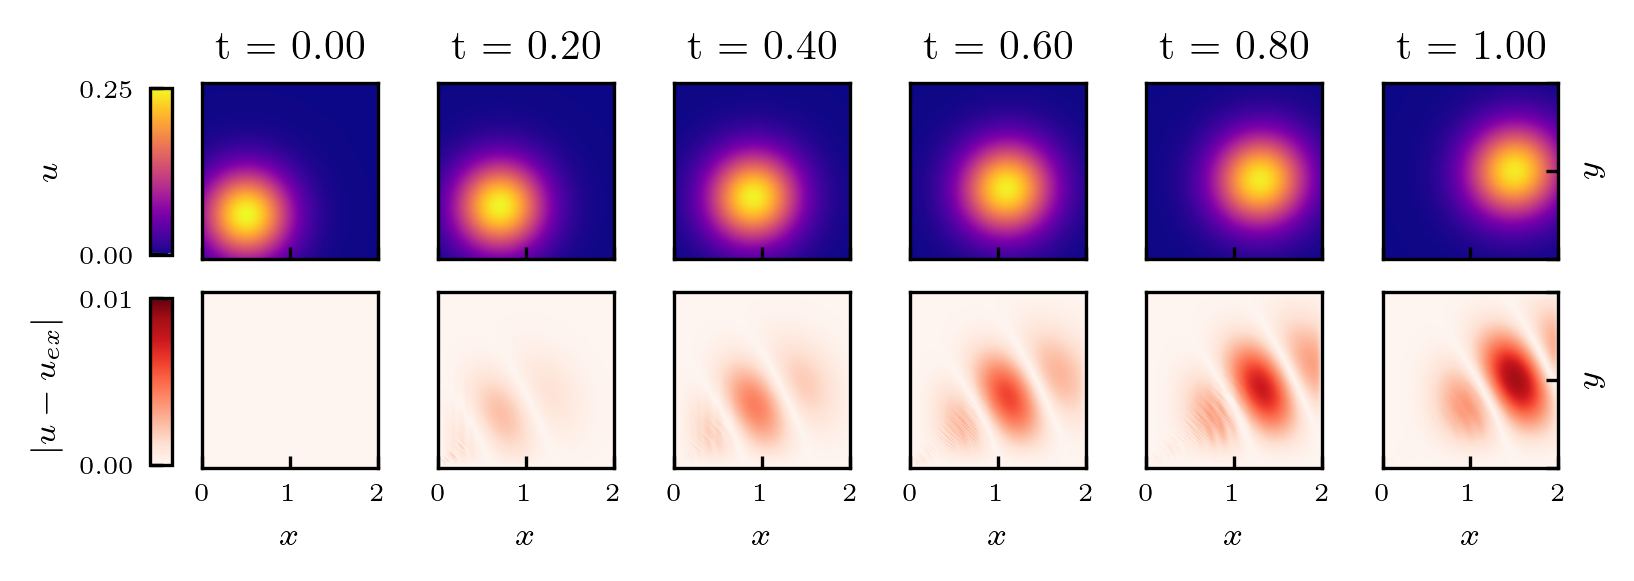

In [104]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

Kt = 6

X, Y = problem.coords
Nx, Ny = problem.shape

zmin = uIMEX.min()
zmax = uIMEX.max()

u_exact = lambda t : problem.exact_solution(t, X, Y).reshape((Nx, Ny))

# Setup figure with two 3D subplots
fig, axs = plt.subplots(2, Kt, figsize=(5, 2), sharex=True, sharey=True)
fig.subplots_adjust(left=0.15, wspace=0.2, hspace=0.3)

mappables = [[], []]

# Time‐loop
K = int(Nt / (Kt-1))
for n, t in enumerate(tvec[::K]):

    # reshape solution vectors
    Z1 = uIMEX[:, K*n].reshape((Nx, Ny))
    Z2 = np.abs(Z1 - u_exact(t))
    
    im1 = axs[0, n].imshow(Z1, extent=[0, Lx, 0, Ly], vmin=zmin, vmax=zmax,
                           origin='lower', cmap='plasma', aspect='equal')
    im2 = axs[1, n].imshow(Z2, extent=[0, Lx, 0, Ly], vmin=0, vmax=0.01,
                           origin='lower', cmap='Reds', aspect='equal')

    mappables[0].append(im1)
    mappables[1].append(im2)

    axs[1, n].set_xticks([0, 1, 2])
    axs[1, n].set_xlabel("$x$")
    
    for ax in axs[:, n]:
        ax.tick_params(labelleft=False, left=False)
        ax.grid(False)
        if n == Kt - 1:
            ax.yaxis.tick_right()
            ax.yaxis.set_label_position('right')
            ax.set_yticks([0, 1, 2])
            ax.set_ylabel("$y$")

    axs[0, n].set_title(f"t = {t:.2f}")
    
# Add colorbars for each row (on the left)
for i in range(2):

    pos = axs[i, 0].get_position()

    if i == 0:
        cax = fig.add_axes([0, pos.y0 - 0.02, 0.015, pos.y1 - pos.y0 + 0.01])
    else:
        cax = fig.add_axes([0, pos.y0 + 0.065, 0.015, pos.y1 - pos.y0 + 0.01])
        
    if i == 0:
        cbar = fig.colorbar(mappables[i][0], cax=cax, orientation='vertical')
        cax.yaxis.set_ticks([0, 0.25])
        cbar.set_label(r'$u$')
    else:
        cbar = fig.colorbar(mappables[i][1], cax=cax, orientation='vertical')
        cax.yaxis.set_ticks([0, 0.01])
        cbar.set_label(r'$|u - u_{ex}|$')

    cax.yaxis.set_ticks_position('left')
    cax.yaxis.set_label_position('left')

# plt.tight_layout()
# plt.show()

print(os.getcwd())

plt.savefig('advDiff2D_sol.eps')

Go back to `matplotlib inline` (after animation)

In [ ]:
plt.close('all')
from IPython.display import clear_output
clear_output(wait=True)
%matplotlib inline

## Convergence test
We run a convergence test by computing the error at final time for different choices of $N_t$

In [ ]:
# We now run a convergence test and plot the results
# Define the range of Nt values
Nt_values = np.array([2**n for n in range(4, 9)])
errors_imex = []
errors_be = []
# errors_fe = []

# Nt_FE_stable = compute_steps_stability_FE(problem, tspan)
# Loop over Nt values
for k, Nt in enumerate(Nt_values):
    print(f"Running simulation for Nt = {Nt}")
    # Time discretization
    tvec = np.linspace(t0, tf, Nt + 1)
    dt = tvec[1] - tvec[0]

    # Solve the problem with each scheme
    uIMEX, *_ = imexrb(problem, u0, tspan, Nt, epsilon, maxsize, maxsubiter)
    uBE, *_ = backward_euler(problem, u0, tspan, Nt, solver="direct-sparse", typeprec=None)
    # uFE, *_ = forward_euler(problem, u0, tspan, Nt)

    # Compute errors at final time for each scheme
    err_imex = compute_errors(uIMEX, tvec, problem, mode='l2')
    err_be = compute_errors(uBE, tvec, problem, mode='l2')
    # err_fe = compute_errors(uFE, tvec, problem, mode='l2')

    # Store the final error
    errors_imex.append(err_imex)
    errors_be.append(err_be)
    # errors_fe.append(err_fe)


In [ ]:
# Plot the convergence results
plt.figure()
plt.loglog(1 / Nt_values, errors_be, label="Backward Euler", 
           marker='s', markersize=3, linestyle='-', color="tab:orange")
plt.loglog(1 / Nt_values, errors_imex, label="IMEX-RB", 
           marker='o', linestyle='-', color="tab:blue")
# plt.loglog(1 / Nt_values, errors_fe, label="Forward Euler", marker='^', linestyle='-.')
# plt.axvline(1 / Nt_FE_stable, label="Stability FE", color="r", linestyle=':') 
plt.loglog(1 / Nt_values, (Nt_values[0] * errors_be[0] * 0.9) / Nt_values, 
           label=r"$\mathcal{O}(\Delta t)$", color="k", linestyle='--', linewidth=.5)

plt.xlabel(r"$\Delta t$")
plt.ylabel("Relative Error")
plt.title("Convergence Test")
plt.legend()
plt.grid(True, which="both", linewidth=0.5)
plt.show()

order = (np.log(errors_be[1:]) - np.log(errors_be[:-1])) / (np.log(1 / Nt_values[1:]) - np.log(1 / Nt_values[:-1]))
print(order[-1])

### CPU Time to solution

We now compare the times required by IMEX-RB and BE to obtain a stable solution
N.W.: While we will keep $N_t$ fixed for IMEX-RB and BE, we will compute the $N_t$ making FE stable at each different problem size

In [ ]:
# Parameters for the simulation
print("Here some overflow error will be likely thrown by unstable FE")
mu = 1.0
tspan = [0.0, 1.0]
Nt = 200  # Number of time steps for IMEX and BE

# Lists to store CPU times and errors
Nh_list = []
CPU_IMEX_list = []
CPU_BE_list = []
CPU_BEnogmres_list = []
CPU_FE_list = []
CPU_FEunstable_list = []

err_IMEX_list = []
err_BE_list = []
err_FE_list = []

# Loop over different spatial resolutions
Nx_values = [2**val for val in range(4, 9)]
for Nx in Nx_values:
    # Define the problem object
    Ny = Nx
    problem = AdvDiff2D(Nx, Ny, Lx, Ly, mu, vx, vy)
    print(f"Running simulation for Nh = {problem.Nh}")
    Nh_list.append(problem.Nh)

    u0 = problem.initial_condition()
    epsilon = 1e-3  # tolerance parameter
    maxsize = int(np.ceil(np.power(Nx, 1/3)))
    maxsubiter = maxsize

    # Run IMEX-RB integration
    uIMEX, tvec, subiter, CPUtimeIMEX = imexrb(problem, u0, tspan, Nt, epsilon, maxsize, maxsubiter)
    # Run Backward Euler integration
    uBE, _, CPUTimeBE = backward_euler(problem, u0, tspan, Nt)
    *_, CPUTimeBEnogmres = backward_euler(problem, u0, tspan, Nt, solverchoice='directsparse')
    # Run Forward Euler integration on its own stable time grid
    Nt_FE = compute_steps_stability_FE(problem, tspan)
    uFE, tvec_FE, CPUTimeFE = forward_euler(problem, u0, tspan, Nt_FE)
    # Run also an unstable FE for lower ideal bound on CPU time
    *_, CPUTimeFEunstable = forward_euler(problem, u0, tspan, Nt)


    # Compute errors at final time
    err_IMEX = compute_errors(uIMEX, tvec, problem, finaltimeonly=True)
    err_BE = compute_errors(uBE, tvec, problem, finaltimeonly=True)
    err_FE = compute_errors(uFE, tvec_FE, problem, finaltimeonly=True)

    # Append CPU times and errors
    CPU_IMEX_list.append(CPUtimeIMEX)
    CPU_BE_list.append(CPUTimeBE)
    CPU_FE_list.append(CPUTimeFE)
    CPU_FEunstable_list.append(CPUTimeFEunstable)
    CPU_BEnogmres_list.append(CPUTimeBEnogmres)

    err_IMEX_list.append(err_IMEX)
    err_BE_list.append(err_BE)
    err_FE_list.append(err_FE)


In [ ]:

import pickle

# Save all data for CPU time plot to file
data_to_save = {
    "problem_name": problem_name,
    "Nh_list": Nh_list,
    "CPU_IMEX_list": CPU_IMEX_list,
    "CPU_BE_list": CPU_BE_list,
    "CPU_FE_list": CPU_FE_list,
    "CPU_FEunstable_list": CPU_FEunstable_list,
    "CPU_BEnogmres_list": CPU_BEnogmres_list,
    "err_IMEX_list": err_IMEX_list,
    "err_BE_list": err_BE_list,
    "err_FE_list": err_FE_list,
    "tvec": tvec,
    "tvecFE": tvecFE
}

save_file = os.path.join(results_path, "CPUtime.pkl")

with open(save_file, "wb") as f:
    pickle.dump(data_to_save, f)

print(f"Plot data saved to {save_file}")

In [ ]:
# Plotting CPU times vs Nx
plt.figure(figsize=(5,3))
plt.subplot(2, 1, 1)
Nh_array = np.array(Nh_list)
plt.loglog(Nh_array, CPU_IMEX_list, 'o-', label='IMEX-RB')
plt.loglog(Nh_array, CPU_BE_list, 's-', label='Backward Euler (GMRES)')

plt.loglog(Nh_array, CPU_FE_list, '^-', label='Forward Euler (stable)')
plt.loglog(Nh_array, CPU_FEunstable_list, ':', label='Forward Euler (unstable)')
plt.loglog(Nh_array, CPU_BEnogmres_list, 'D:', label='Backward Euler (Direct)')
# plt.loglog(Nh_array, 0.01 * Nh_array, ':', color='k# ', label=r'$\mathcal{O}(N_h)$')
# plt.loglog(Nh_array, 1e-4 * Nh_array**2, '--', color='k', label=r'$\mathcal{O}(N_h^2)$')
# plt.loglog(Nh_array, 1e-8 * Nh_array**3, 'D:', color='k', label=r'$\mathcal{O}(N_h^3)$')
plt.xlabel(r'$N_h$')
plt.ylabel('CPU Time (s)')
# plt.title('CPU Time vs Spatial Resolution')
plt.legend()
plt.grid(True)

# Plotting errors at final time vs Nx
plt.subplot(2, 1, 2)
plt.loglog(Nh_array, err_IMEX_list, 'o-', label='IMEX-RB')
plt.loglog(Nh_array, err_BE_list, 's-', label='Backward Euler')
plt.loglog(Nh_array, err_FE_list, '^-', label='Forward Euler (stable)')
plt.xlabel(r'$N_h$')
plt.ylabel(r'Error')
# plt.title('Error vs num of unknowns')
plt.legend()
plt.grid(True)

# plt.tight_layout()
plt.savefig(os.path.join(results_path, "CPUTime.pdf"))
plt.show()


In [ ]:
import sympy as sp
from sympy.utilities.iterables import capture

# --- 1) Define symbols ---
# spatial coords and time
x1, x2, t = sp.symbols('x1 x2 t', real=True)
# components of the "center" x0 and velocity c
x01, x02 = sp.symbols('x01 x02', real=True)
c1, c2 = sp.symbols('c1 c2', real=True)
# constants
U, sigma, mu, D = sp.symbols('U sigma mu D', positive=True)

# --- 2) Build the solution u ---
# displacement vector = x - x0 - c t
dx1 = x1 - x01 - c1*t
dx2 = x2 - x02 - c2*t

den = sigma**2 + mu*t
arg = (dx1**2 + dx2**2)/den

u = U* sp.exp(-arg)

#--- 3) Compute derivatives ---
u_t   = sp.diff(u, t)
u_x1  = sp.diff(u, x1)
u_x2  = sp.diff(u, x2)

# advection term c·grad u
adv = c1*u_x1 + c2*u_x2 

# Laplacian Δu
lap = sp.diff(u, x1, 2) + sp.diff(u, x2, 2) 

#--- 4) Assemble the LHS of the advection-diffusion equation ---
LHS = sp.simplify(u_t + adv - mu*lap)

#--- 5) (Optional) print a more compact form ---
_tmp = capture(lambda: sp.pprint(LHS, use_unicode=True)) .rstrip('\n')
print(_tmp)

In [ ]:
def f(t, x, y):
    diff_x = x - x0 - cx*t
    diff_y = y - y0 - cy*t
    den = sigma**2 + mu*t
    
    sol = (U / den) * ( mu * (diff_x**2 + diff_y**2) + 4 * mu * (den - diff_x**2 - diff_y**2)) * np.exp(-(diff_x**2 + diff_y**2) / den)

    return sol